In [ ]:
!pip install datasets
!pip install evaluate
!pip install torchtext
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [1]:
import os
import nltk
import math
import torch
import datasets
import torchtext
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import evaluate as evaluation_metrics
from timeit import default_timer as timer
from torch.nn.utils.rnn import pad_sequence

In [ ]:
train_data = datasets.load_dataset("wmt16", "de-en", split="train[:50000]")
val_data = datasets.load_dataset("wmt16", "de-en", split="validation")
test_data = datasets.load_dataset("wmt16", "de-en", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [ ]:
SOURCE_LANGUAGE = "de"
TARGET_LANGUAGE = "en"
len(train_data), len(val_data), len(test_data)

(50000, 2169, 2999)

In [ ]:
nltk.download("punkt")

token_transform = {}
vocab_transform = {}

token_transform[SOURCE_LANGUAGE] = nltk.tokenize.word_tokenize
token_transform[TARGET_LANGUAGE] = nltk.tokenize.word_tokenize

def yield_tokens(data_iter, language):
    for data_sample in data_iter:
        yield token_transform[language](data_sample["translation"][language])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

for ln in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[ln] = torchtext.vocab.build_vocab_from_iterator(
        yield_tokens(train_data, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True
    )

for ln in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(torch.nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(torch.nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(torch.nn.Module):
    def __init__(
            self, num_encoder_layers: int, num_decoder_layers: int, emb_size: int,
            nhead: int, src_vocab_size: int, tgt_vocab_size: int,
            dim_feedforward: int = 512, dropout: float = 0.1
        ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = torch.nn.Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = torch.nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(
            self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask,
            memory_key_padding_mask
        ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src_emb, tgt_emb, src_mask, tgt_mask, None,
            src_padding_mask, tgt_padding_mask, memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
SRC_VOCAB_SIZE = len(vocab_transform[SOURCE_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TARGET_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 42
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
    NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM
)

for p in transformer.parameters():
    if p.dim() > 1:
        torch.nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.SGD(transformer.parameters(), lr=5e-4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for entry in batch:
        src_sample = entry["translation"]["de"]
        tgt_sample = entry["translation"]["en"]
        src_batch.append(text_transform[SOURCE_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TARGET_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.float(), tgt_batch

In [ ]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    losses = 0

    for i, (src, tgt) in enumerate(dataloader):
        if i % 100 == 0:
            print("Batch", i, "of", len(dataloader))

        with torch.autocast(device_type="cuda"):
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss.item()

    return losses / len(list(dataloader))


def evaluate(model, dataloader):
    model.eval()
    losses = 0
    for src, tgt in dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(dataloader))

In [ ]:
NUM_EPOCHS = 50

TRAIN_LOSSES, VAL_LOSSES = [], []
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_dataloader, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer, val_dataloader)
    TRAIN_LOSSES.append(train_loss)
    VAL_LOSSES.append(val_loss)

    torch.save(transformer.state_dict(), f"MY_TRANSPHOBIA_{epoch}.pth")

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SOURCE_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TARGET_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/NLP Transformer")
os.listdir()

['MY_TRANSPHOBIA_train_loss_7pt0_val_loss_7pt5.pth',
 'MY_TRANSPHOBIA_train_loss_6pt27_val_loss_7pt13.pth',
 'MY_TRANSPHOBIA_train_loss_6pt1_val_loss_7pt1.pth',
 'MY_TRANSPHOBIA_train_loss_6pt08_val_loss_7pt05.pth',
 'MY_TRANSPHOBIA_train_loss_5pt9_val_loss_6pt95.pth',
 'MY_TRANSPHOBIA_epoch_46_train_5.61_val_6.83.pth',
 'MY_TRANSPHOBIA_epoch_48_train_5.49_val_6.75.pth',
 'MY_TRANSPHOBIA_epoch_50_train_5.40_val_6.71.pth']

In [ ]:
transformer.load_state_dict(torch.load("MY_TRANSPHOBIA_epoch_50_train_5.40_val_6.71.pth"))

<All keys matched successfully>

In [ ]:
print(train_data[91]["translation"]["en"])
print(translate(transformer, train_data[91]["translation"]["de"]))

Your Group was alone in advocating what you are saying now.
 I would like to be a very very very very very very . 


In [ ]:
bleu_metric = evaluation_metrics.load("bleu")

In [ ]:
val_translations = [[], []]
for i, sentence in enumerate(val_data):
    translation = translate(transformer, sentence["translation"]["de"])
    val_translations[0].append(translation)
    val_translations[1].append([sentence["translation"]["en"]])
    if i % 500 == 0:
        print(i, "of", len(val_data))

0 of 2169
500 of 2169
1000 of 2169
1500 of 2169
2000 of 2169


In [ ]:
val_bleu_1 = bleu_metric.compute(predictions=val_translations[0], references=val_translations[1], max_order=1)
val_bleu_2 = bleu_metric.compute(predictions=val_translations[0], references=val_translations[1], max_order=2)
val_bleu_3 = bleu_metric.compute(predictions=val_translations[0], references=val_translations[1], max_order=3)
val_bleu_4 = bleu_metric.compute(predictions=val_translations[0], references=val_translations[1], max_order=4)

In [ ]:
val_bleu_1

{'bleu': 0.16442556304305342,
 'precisions': [0.19620958751393533],
 'brevity_penalty': 0.8380098298273803,
 'length_ratio': 0.8498159033654157,
 'translation_length': 39468,
 'reference_length': 46443}

In [ ]:
val_bleu_2

{'bleu': 0.03595696356452455,
 'precisions': [0.19620958751393533, 0.009383126457735718],
 'brevity_penalty': 0.8380098298273803,
 'length_ratio': 0.8498159033654157,
 'translation_length': 39468,
 'reference_length': 46443}

In [ ]:
val_bleu_3

{'bleu': 0.00737355565748487,
 'precisions': [0.19620958751393533,
  0.009383126457735718,
  0.0003700119542323675],
 'brevity_penalty': 0.8380098298273803,
 'length_ratio': 0.8498159033654157,
 'translation_length': 39468,
 'reference_length': 46443}

In [ ]:
val_bleu_4

{'bleu': 0.002351278717782944,
 'precisions': [0.19620958751393533,
  0.009383126457735718,
  0.0003700119542323675,
  9.097801364670205e-05],
 'brevity_penalty': 0.8380098298273803,
 'length_ratio': 0.8498159033654157,
 'translation_length': 39468,
 'reference_length': 46443}

In [ ]:
test_translations = [[], []]
for i, sentence in enumerate(test_data):
    translation = translate(transformer, sentence["translation"]["de"])
    test_translations[0].append(translation)
    test_translations[1].append([sentence["translation"]["en"]])
    if i % 500 == 0:
        print(i, "of", len(test_data))

0 of 2999
500 of 2999
1000 of 2999
1500 of 2999
2000 of 2999
2500 of 2999


In [ ]:
test_bleu_1 = bleu_metric.compute(predictions=test_translations[0], references=test_translations[1], max_order=1)
test_bleu_2 = bleu_metric.compute(predictions=test_translations[0], references=test_translations[1], max_order=2)
test_bleu_3 = bleu_metric.compute(predictions=test_translations[0], references=test_translations[1], max_order=3)
test_bleu_4 = bleu_metric.compute(predictions=test_translations[0], references=test_translations[1], max_order=4)

In [ ]:
test_bleu_1

{'bleu': 0.16344248560432287,
 'precisions': [0.19129618598942258],
 'brevity_penalty': 0.8543948995060475,
 'length_ratio': 0.8640340616665887,
 'translation_length': 55401,
 'reference_length': 64119}

In [ ]:
test_bleu_2

{'bleu': 0.03377223136270125,
 'precisions': [0.19129618598942258, 0.008167627189801916],
 'brevity_penalty': 0.8543948995060475,
 'length_ratio': 0.8640340616665887,
 'translation_length': 55401,
 'reference_length': 64119}

In [ ]:
test_bleu_3

{'bleu': 0.0056202519110364205,
 'precisions': [0.19129618598942258,
  0.008167627189801916,
  0.00018217517154828653],
 'brevity_penalty': 0.8543948995060475,
 'length_ratio': 0.8640340616665887,
 'translation_length': 55401,
 'reference_length': 64119}

In [ ]:
test_bleu_4

{'bleu': 0.0013445840783108415,
 'precisions': [0.19129618598942258,
  0.008167627189801916,
  0.00018217517154828653,
  2.154893763737448e-05],
 'brevity_penalty': 0.8543948995060475,
 'length_ratio': 0.8640340616665887,
 'translation_length': 55401,
 'reference_length': 64119}

In [ ]:
meteor_metric = evaluation_metrics.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
val_translations = [[], []]
for i, sentence in enumerate(val_data):
    translation = translate(transformer, sentence["translation"]["de"])
    val_translations[0].append(translation)
    val_translations[1].append(sentence["translation"]["en"])
    if i % 500 == 0:
        print(i, "of", len(val_data))

0 of 2169
500 of 2169
1000 of 2169
1500 of 2169
2000 of 2169


In [ ]:
val_result = meteor_metric.compute(predictions=val_translations[0], references=val_translations[1])
val_result

{'meteor': 0.0930770368569676}

In [ ]:
test_translations = [[], []]
for i, sentence in enumerate(test_data):
    translation = translate(transformer, sentence["translation"]["de"])
    test_translations[0].append(translation)
    test_translations[1].append(sentence["translation"]["en"])
    if i % 500 == 0:
        print(i, "of", len(test_data))

0 of 2999
500 of 2999
1000 of 2999
1500 of 2999
2000 of 2999
2500 of 2999


In [ ]:
test_result = meteor_metric.compute(predictions=test_translations[0], references=test_translations[1])
test_result

{'meteor': 0.09212221815050958}

In [ ]:
bertscore_metric = evaluation_metrics.load("bertscore")

In [ ]:
val_result = bertscore_metric.compute(predictions=val_translations[0], references=val_translations[1], lang="en")

# Mean and Std of Precision
mean_prec, std_prec = np.mean(val_result["precision"]), np.std(val_result["precision"])

# Mean and Std of Recall
mean_recall, std_recall = np.mean(val_result["recall"]), np.std(val_result["recall"])

# Mean and Std of F1
mean_f1, std_f1 = np.mean(val_result["f1"]), np.std(val_result["f1"])

print("Mean, Std of Precision:", mean_prec, std_prec)
print("Mean, Std of Recall:", mean_recall, std_recall)
print("Mean, Std of F1:", mean_f1, std_f1)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean, Std of Precision: 0.8022212876653605 0.03459823501474511
Mean, Std of Recall: 0.8281202503424627 0.033317884472373
Mean, Std of F1: 0.814725629933807 0.031121453237019894


In [ ]:
test_result = bertscore_metric.compute(predictions=test_translations[0], references=test_translations[1], lang="en")

# Mean and Std of Precision
mean_prec, std_prec = np.mean(test_result["precision"]), np.std(test_result["precision"])

# Mean and Std of Recall
mean_recall, std_recall = np.mean(test_result["recall"]), np.std(test_result["recall"])

# Mean and Std of F1
mean_f1, std_f1 = np.mean(test_result["f1"]), np.std(test_result["f1"])

print("Mean, Std of Precision:", mean_prec, std_prec)
print("Mean, Std of Recall:", mean_recall, std_recall)
print("Mean, Std of F1:", mean_f1, std_f1)

Mean, Std of Precision: 0.8024146203678344 0.024223419916662915
Mean, Std of Recall: 0.8257890106757986 0.022099675408108598
Mean, Std of F1: 0.813690240043686 0.018726632126907422


In [2]:
with open("losses_2a.csv") as file:
    losses = file.readlines()

train_losses = [float(loss) for loss in losses[0].split(",")]
val_losses = [float(loss) for loss in losses[1].split(",")]

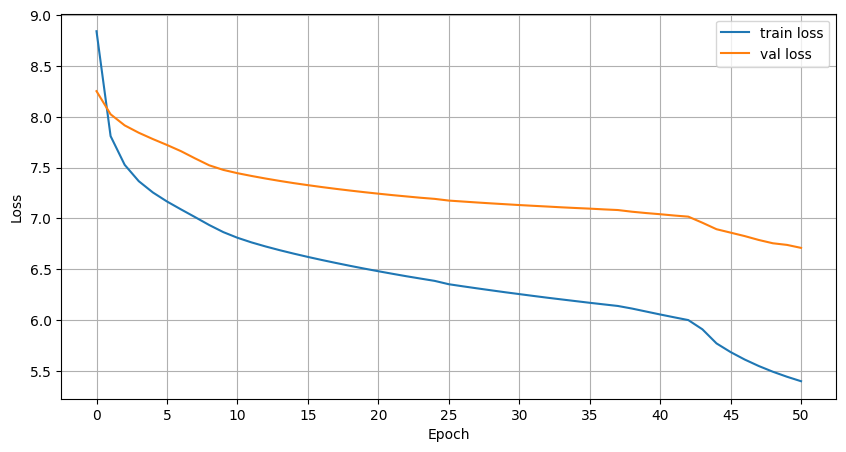

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 51), train_losses, label="train loss")
plt.plot(range(0, 51), val_losses, label="val loss")
plt.xticks(range(0, 51, 5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()